In [8]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

TEMPLATE FOR IMPLEMENT AND WORK ON SEVERAL CLUSTERING TECHNIQUES

K-means
Hierarchical Clustering (Agglomerative Clustering)
Affinity Propagation


In [5]:
# load dataset
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dataset = read_csv('/content/drive/My Drive/Data_MasterTemplate.csv',index_col=0)

In [7]:
dataset

MMM         AXP        AAPL  ...       V        WMT        WBA
Date                                            ...                              
2000-01-03   29.847043   35.476634    3.530576  ...     NaN  47.337599  21.713237
2000-01-04   28.661131   34.134275    3.232839  ...     NaN  45.566248  20.907354
2000-01-05   30.122175   33.959430    3.280149  ...     NaN  44.503437  21.097421
2000-01-06   31.877325   33.959430    2.996290  ...     NaN  45.126952  20.527220
2000-01-07   32.509812   34.433913    3.138219  ...     NaN  48.535033  21.051805
...                ...         ...         ...  ...     ...        ...        ...
2019-01-31  200.300000  102.700000  166.440000  ...  135.01  95.830000  72.260000
2019-02-01  199.160000  103.060000  166.520000  ...  140.15  93.860000  71.880000
2019-02-04  200.210000  103.420000  171.250000  ...  141.50  94.770000  71.460000
2019-02-05  201.120000  103.900000  174.180000  ...  142.53  95.600000  71.310000
2019-02-06  202.570000  104.960000  174.240000  ...  141.49  95.640000  71.470000

[4804 rows x 30 columns]

In [10]:
# Data analysis - Statistics
dataset.shape

(4804, 30)

In [11]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

MMM        AXP      AAPL  ...   V        WMT        WBA
Date                                        ...                          
2000-01-03  29.847043  35.476634  3.530576  ... NaN  47.337599  21.713237
2000-01-04  28.661131  34.134275  3.232839  ... NaN  45.566248  20.907354
2000-01-05  30.122175  33.959430  3.280149  ... NaN  44.503437  21.097421
2000-01-06  31.877325  33.959430  2.996290  ... NaN  45.126952  20.527220
2000-01-07  32.509812  34.433913  3.138219  ... NaN  48.535033  21.051805

[5 rows x 30 columns]

In [12]:
# describe data
set_option('precision', 3)
dataset.describe()

MMM       AXP      AAPL  ...         V       WMT       WBA
count  4804.000  4804.000  4804.000  ...  2741.000  4804.000  4804.000
mean     86.769    49.659    49.107  ...    53.323    50.767    41.697
std      53.942    22.564    55.020  ...    37.647    17.040    19.937
min      25.140     8.713     0.828  ...     9.846    30.748    17.317
25%      51.192    34.079     3.900  ...    18.959    38.062    27.704
50%      63.514    42.274    23.316  ...    45.207    42.782    32.706
75%     122.906    66.816    84.007  ...    76.966    65.076    58.165
max     251.981   112.421   231.260  ...   150.525   107.010    90.188

[8 rows x 30 columns]

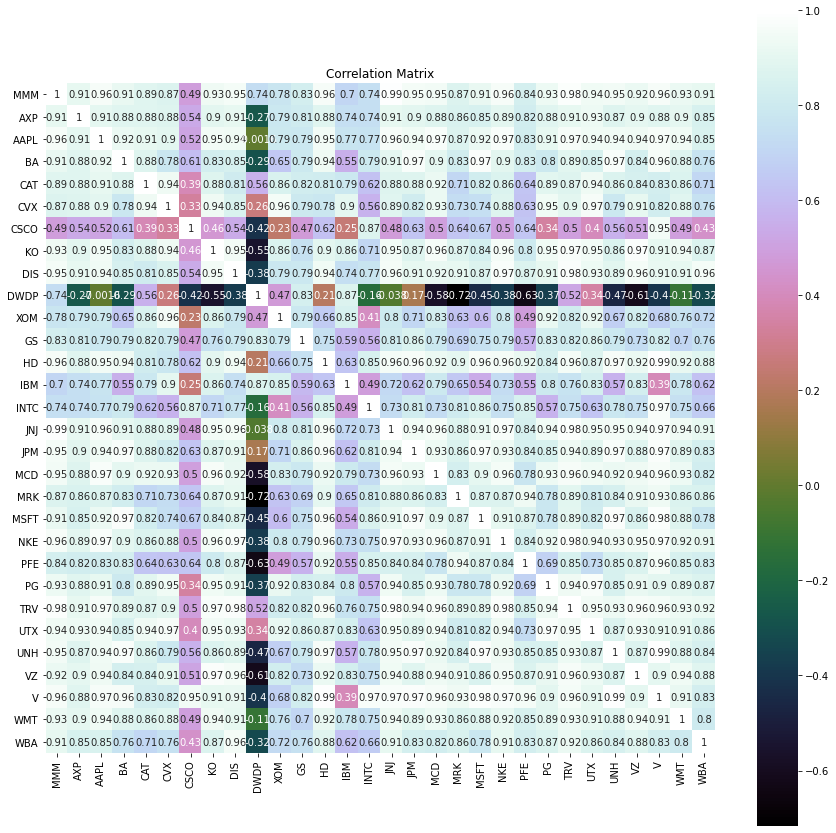

In [13]:
# CORRELATION
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [14]:
# DATA PRE PROCESSING 

#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [15]:
# >30 % NULL 
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(4804, 28)

In [16]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
#dataset= dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())

dataset.head(2)

MMM     AXP   AAPL     BA  ...    UNH      VZ     WMT     WBA
Date                                      ...                               
2000-01-03  29.847  35.477  3.531  26.65  ...  5.841  22.564  47.338  21.713
2000-01-04  28.661  34.134  3.233  26.61  ...  5.766  21.834  45.566  20.907

[2 rows x 28 columns]

In [17]:
# Data Transformation

#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns
#format the data as a numpy array to feed into the K-Means algorithm
#data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

Returns  Volatility
MMM    0.059      -1.010
AXP   -0.075       1.115

In [ ]:
# Evaluate Algorithms and Models


# KMeans
# Hierarchial clustering
# Affinity Propagation clustering

In [20]:
nclust=6
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
centroids, assignments, inertia = k_means.cluster_centers_, k_means.labels_, k_means.inertia_

In [22]:
#Extracting labels 
target_labels = k_means.predict(X)
#Printing the labels
target_labels

array([1, 0, 3, 2, 2, 1, 0, 4, 5, 4, 0, 5, 4, 0, 1, 0, 1, 4, 5, 2, 4, 4,
       5, 5, 2, 4, 4, 5], dtype=int32)

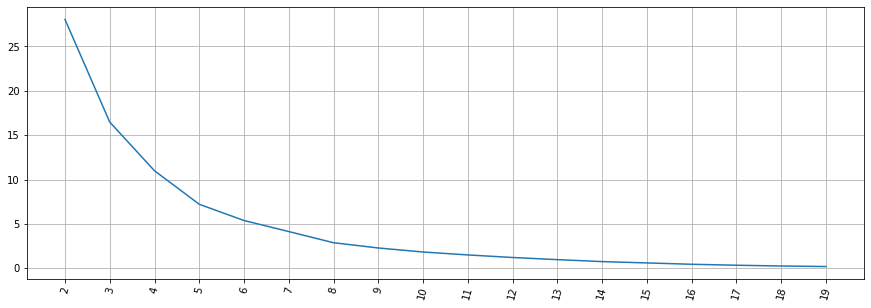

In [23]:

# Find optimal num of clusters 

distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans_test = KMeans(n_clusters=k)
    kmeans_test.fit(X)
    distorsions.append(kmeans_test.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [24]:
k_means.labels_

array([1, 0, 3, 2, 2, 1, 0, 4, 5, 4, 0, 5, 4, 0, 1, 0, 1, 4, 5, 2, 4, 4,
       5, 5, 2, 4, 4, 5], dtype=int32)

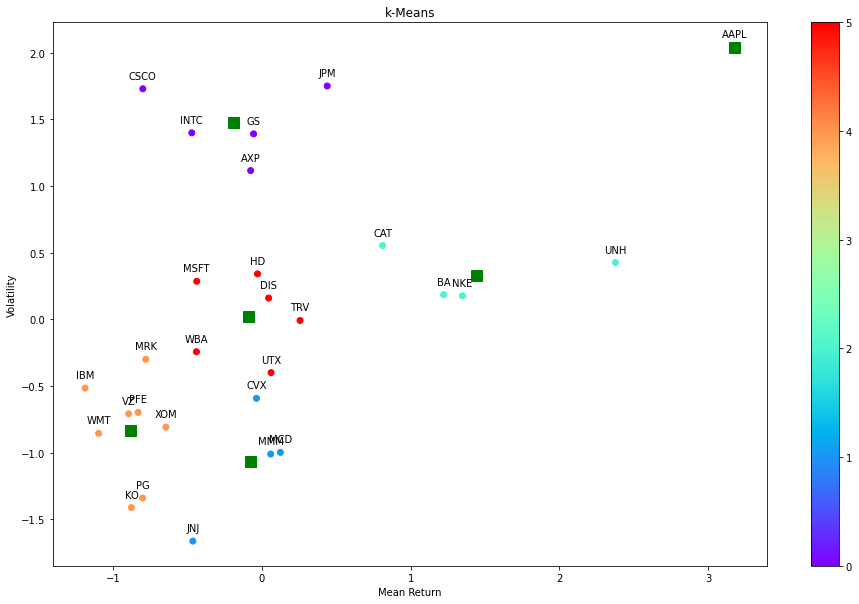

In [25]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

In [26]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(k_means.labels_)],axis = 1)
cluster_label.columns =['Company','Cluster']
cluster_label.sort_values(by=['Cluster'])

Company  Cluster
13    INTC        0
1      AXP        0
15     JPM        0
10      GS        0
6     CSCO        0
16     MCD        1
14     JNJ        1
0      MMM        1
5      CVX        1
4      CAT        2
3       BA        2
24     UNH        2
19     NKE        2
2     AAPL        3
17     MRK        4
9      XOM        4
25      VZ        4
12     IBM        4
26     WMT        4
7       KO        4
20     PFE        4
21      PG        4
23     UTX        5
8      DIS        5
18    MSFT        5
11      HD        5
22     TRV        5
27     WBA        5

In [ ]:
# Hierarchical Clustering (Agglomerative Clustering)


In [27]:
nclust = 4
model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = model.fit_predict(X)

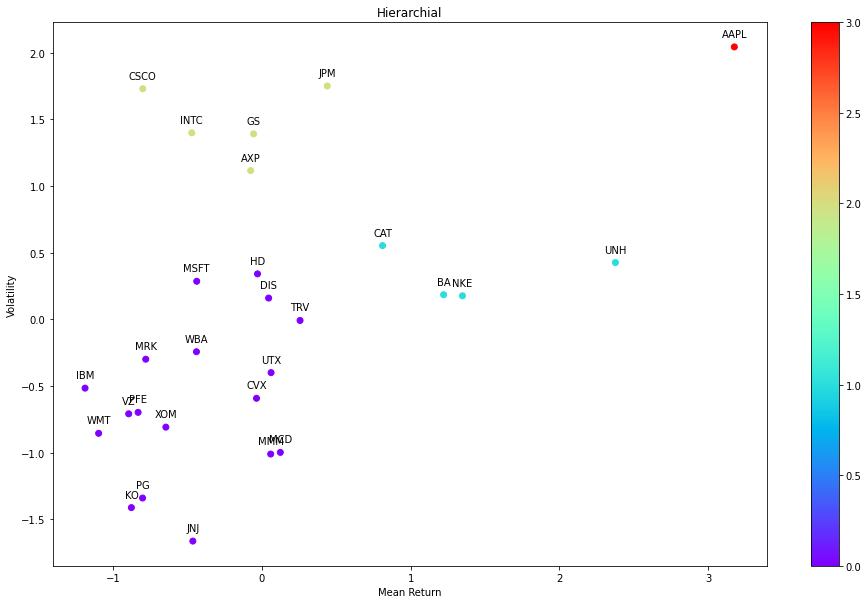

In [28]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchial')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [29]:
# Hierarchy Graph/ Dendogram
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
Z[0]

array([20.        , 25.        ,  0.06407423,  2.        ])

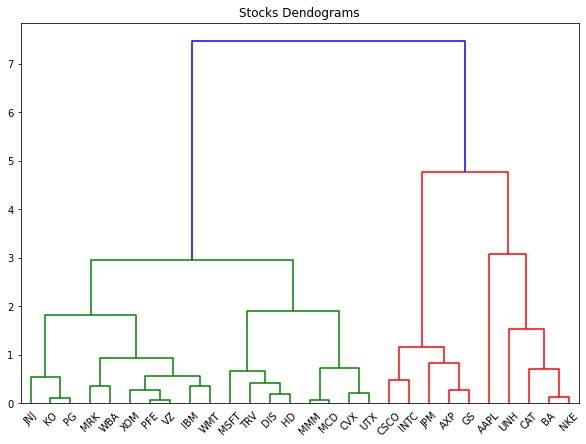

In [30]:
# Plot 
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendograms")
dendrogram(Z,labels = X.index)
plt.show()

In [31]:
distance_threshold = 2.5
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])

chosen_clusters['cluster'].unique()
# array([4, 5, 2, 3, 1], dtype=int64)

array([2, 3, 5, 4, 1], dtype=int32)

In [32]:
# Cophenetic Correlation coefficient
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab
c, coph_dists = cophenet(Z, pdist(X))
c

0.693558090937627

In [33]:
# linkage types


methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(rescaledDataset)

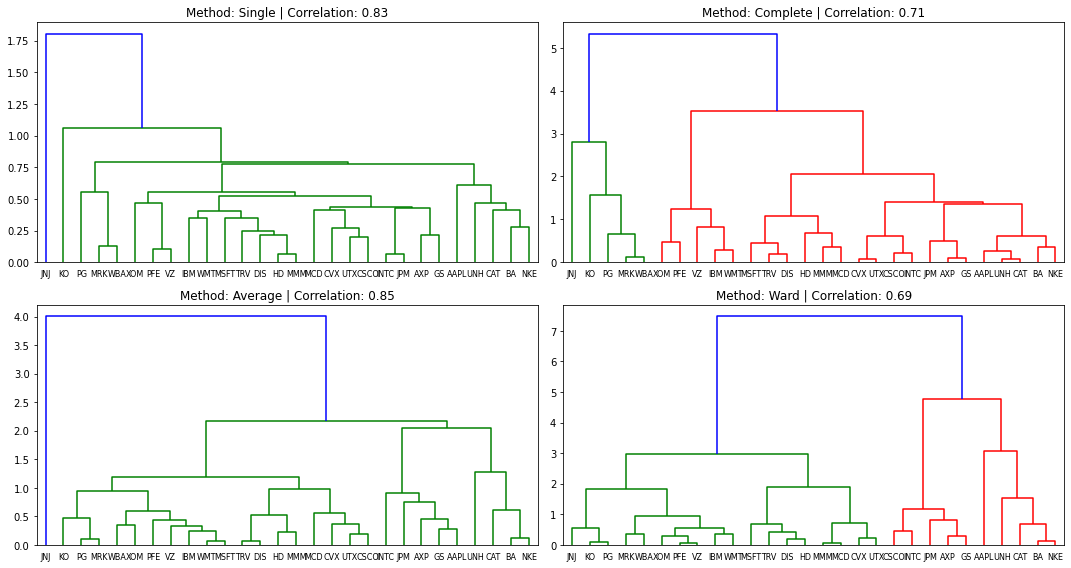

In [34]:
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(X, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, labels=X.index,
        orientation='top', leaf_rotation=0., 
        leaf_font_size=8., ax = axes[i])
    axes[i].set_title('Method: {} | Correlation: {:.2f}'.format(
                                                method.capitalize(), c))
    
fig.tight_layout()

In [35]:
# Affinity Propagation
ap = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
ap.fit(X)
clust_labels2 = ap.predict(X)

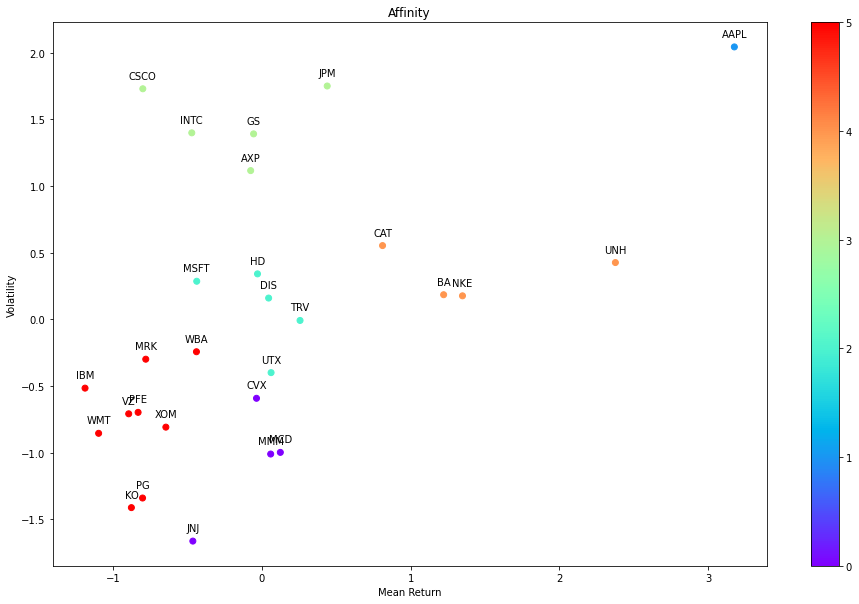

In [36]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [37]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
n_clusters_ = len(cluster_centers_indices)

Estimated number of clusters: 6


<Figure size 432x288 with 0 Axes>

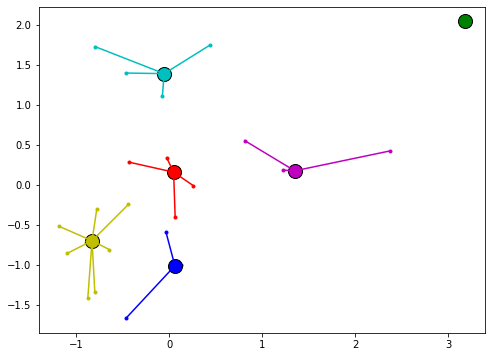

In [38]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
no_clusters = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

In [39]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(ap.labels_)],axis = 1)
cluster_label.columns =['Company','Cluster']
cluster_label.sort_values(by=['Cluster'])

Company  Cluster
0      MMM        0
5      CVX        0
16     MCD        0
14     JNJ        0
2     AAPL        1
23     UTX        2
22     TRV        2
18    MSFT        2
8      DIS        2
11      HD        2
15     JPM        3
13    INTC        3
6     CSCO        3
1      AXP        3
10      GS        3
4      CAT        4
19     NKE        4
3       BA        4
24     UNH        4
12     IBM        5
26     WMT        5
9      XOM        5
7       KO        5
17     MRK        5
20     PFE        5
21      PG        5
25      VZ        5
27     WBA        5